<a href="https://colab.research.google.com/github/agarwalanant/CustomerBehaviorPrediction/blob/master/EDA_of_the_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import the needed librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability and cleaner presentation


pd.set_option('display.float_format', lambda x: '%.3f' % x) #Limiting floats output to 3 decimal points


from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



In [0]:
#Now let's get and put the data in  pandas dataframe

order_products_train = pd.read_csv('../input/order_products__train.csv')
order_products_prior = pd.read_csv('../input/order_products__prior.csv')
orders = pd.read_csv('../input/orders.csv')
products = pd.read_csv('../input/products.csv')
aisles = pd.read_csv('../input/aisles.csv')
departments = pd.read_csv('../input/departments.csv')

Explored  **order_products_train** and  **order_products_prior** files.   These files specify which products were purchased in each order. More specifically, **order_products__prior** contains previous order contents for all customers and  **order_products_train**  contains the last orders for some customers only.

In [0]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


In [0]:
#display first five rows.

order_products_train.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [0]:
#display first five rows. 

order_products_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


concatenate them in the same order_products dataframe.

In [0]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)

print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


In [0]:
#display first five rows.

order_products_all.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


##Missing Data

In [0]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data


,Total Missing,Percent
reordered,0,0.000
add_to_cart_order,0,0.000
product_id,0,0.000
order_id,0,0.000


There is no missing data in order_products_all dataset. 

In [0]:
# Check the number of unique orders and unique products
orders_Unique = len(set(order_products_all.order_id))
products_Unique = len(set(order_products_all.product_id))
print("There are %s orders for %s products" %(orders_Unique, products_Unique))

There are 3346083 orders for 49685 products


**Number of products that people usually order :**

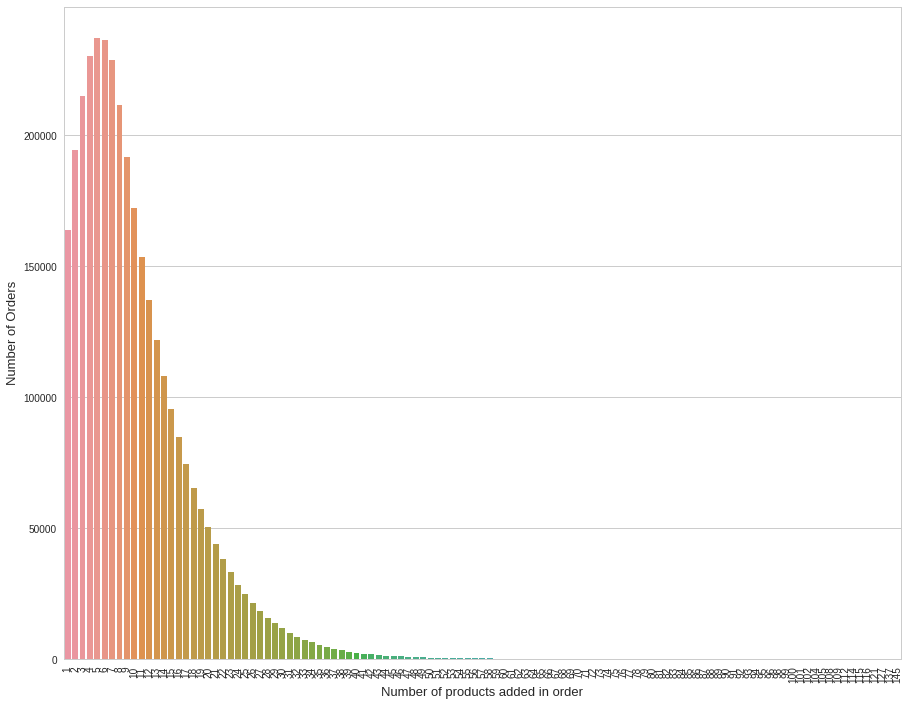

In [0]:
grouped = order_products_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)

plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

Observation : people usually order around 5 products.

##Most ordered Products

identify which products are ordered the most.

In [0]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'count'}).reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.sort_values(by='Total_reorders', ascending=False)[:10]
grouped

,product_id,Total_reorders,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
47762,47766,184224,Organic Avocado
47622,47626,160792,Large Lemon
16794,16797,149445,Strawberries
26206,26209,146660,Limes
27842,27845,142813,Organic Whole Milk


Fruits like banana , strawberries...are  the most ordered products.

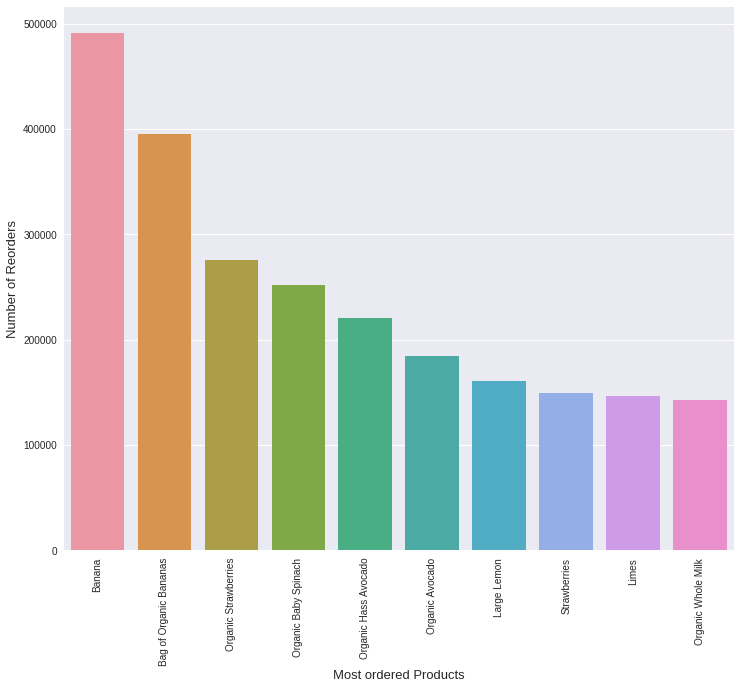

In [0]:
grouped  = grouped.groupby(['product_name']).sum()['Total_reorders'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most ordered Products', fontsize=13)
plt.show()

###Reorder Frequency:

Do people usually reorder the same previous ordered products ?

In [0]:
grouped = order_products_all.groupby("reordered")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped

,reordered,Total_products,Ratios
0,0,13863746,0.410
1,1,19955360,0.590


**59 %** of ordered products are previously ordered by customers.

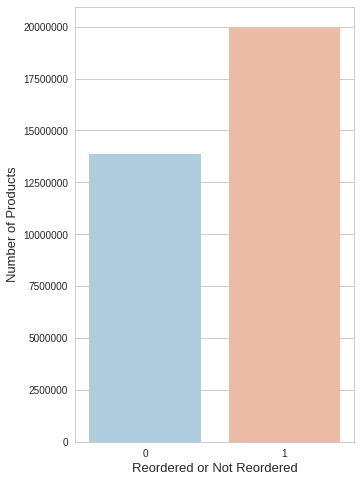

In [0]:
grouped  = grouped.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(grouped.index, grouped.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

##Most Reordered Products

Which products are usually reordered ? 

In [0]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped[grouped.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:10]
grouped

,product_id,reorder_sum,reorder_total,reorder_probability,product_name
2074,2075,84,90,0.933,Serenity Ultimate Extrema Overnight Pads
27737,27740,94,102,0.922,Chocolate Love Bar
35601,35604,93,104,0.894,Maca Buttercups
38248,38251,99,111,0.892,Benchbreak Chardonnay
36798,36801,88,99,0.889,Organic Blueberry B Mega
10233,10236,114,131,0.870,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.868,Thousand Island Salad Snax
5455,5457,78,90,0.867,Classic Carbonated Natural Mineral Water
35493,35496,394,457,0.862,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.861,Half And Half Ultra Pasteurized


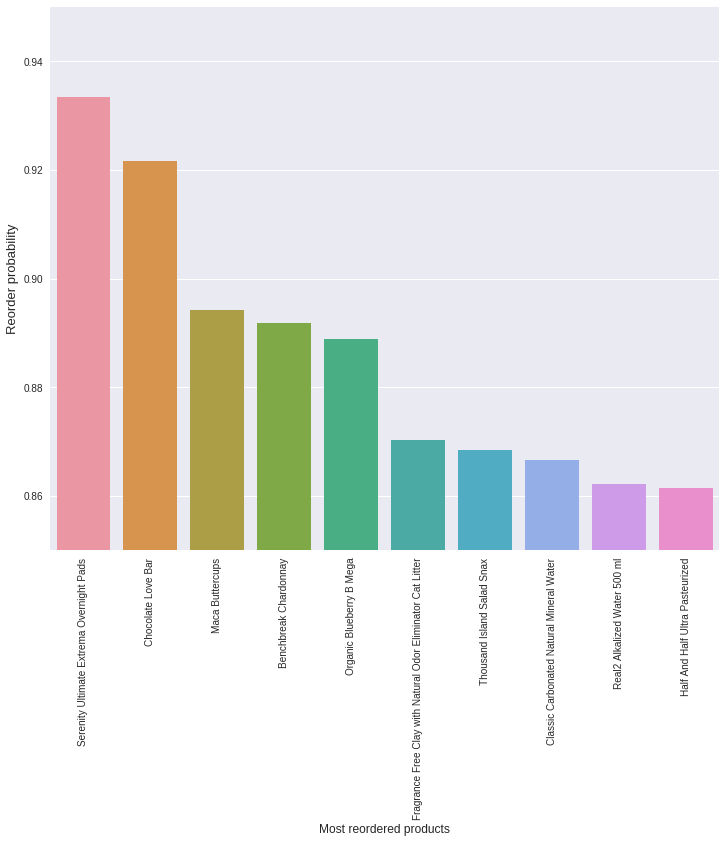

In [0]:
grouped  = grouped.groupby(['product_name']).sum()['reorder_probability'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylim([0.85,0.95])
plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('Most reordered products', fontsize=12)
plt.show()

Let's explore now the orders.csv file

In [0]:
print("The orders data size is : ", orders.shape)
print("Columns in orders data  are : ",  orders.columns.values)

The orders data size is :  (3421083, 7)
Columns in orders data  are :  ['order_id' 'user_id' 'eval_set' 'order_number' 'order_dow'
 'order_hour_of_day' 'days_since_prior_order']


In [0]:
#display first five rows of our dataset.

orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,nan
1,2398795,1,prior,2,3,7,15.000
2,473747,1,prior,3,3,12,21.000
3,2254736,1,prior,4,4,7,29.000
4,431534,1,prior,5,4,15,28.000


##Missing Data

In [0]:
orders_na = (orders.isnull().sum() / len(orders)) * 100
orders_na = orders_na.drop(orders_na[orders_na == 0].index).sort_values(ascending=False)
orders_na

days_since_prior_order   6.028
dtype: float64

The only feature with missing values is **days_since_prior_order** with **6.028 %** missing


##Time of orders

Time at which people usually order products.

**Hours of Order in a Day:** 

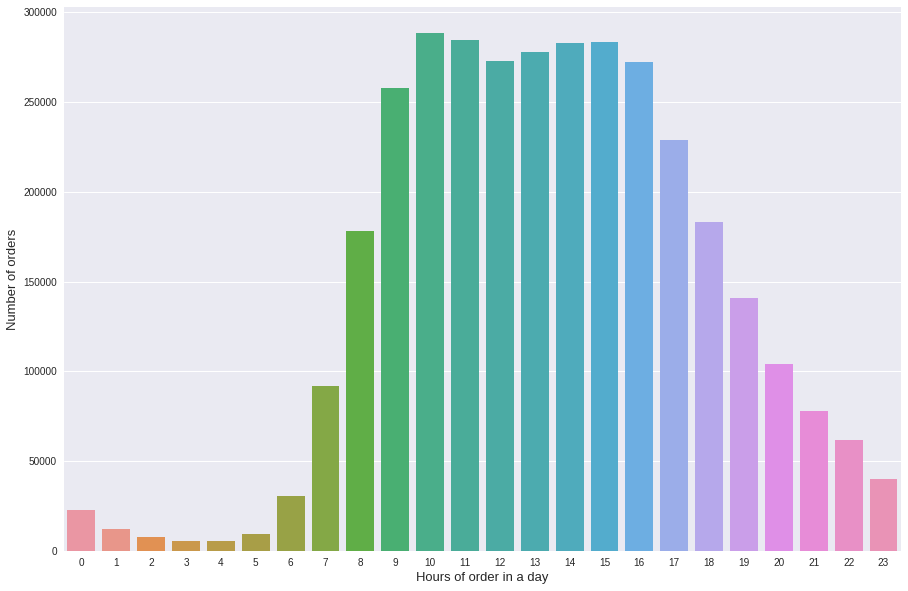

In [0]:
grouped = orders.groupby("order_id")["order_hour_of_day"].aggregate("sum").reset_index()
grouped = grouped.order_hour_of_day.value_counts()

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Hours of order in a day', fontsize=13)
plt.show()

People mostly order between  8  and 19 (anonimyzed hours and probably between 8 a.m and 7 p.m.)


 **Days of Orders in a week:**

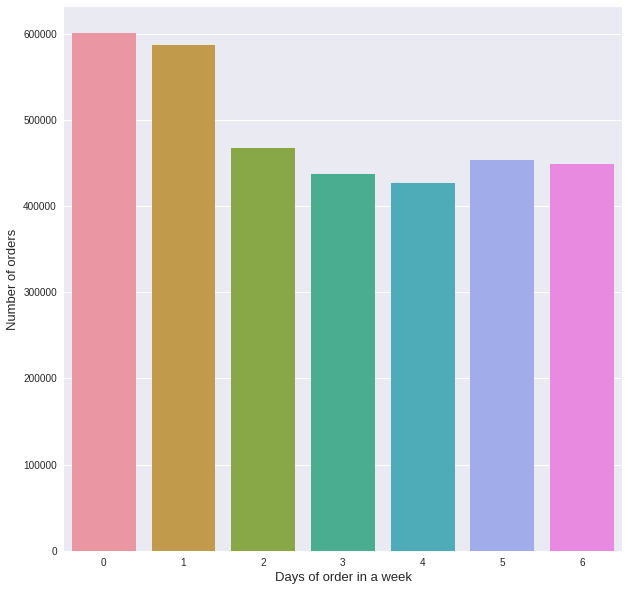

In [0]:
grouped = orders.groupby("order_id")["order_dow"].aggregate("sum").reset_index()
grouped = grouped.order_dow.value_counts()

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Days of order in a week', fontsize=13)
plt.show()

People usually order at days 0 and 1 (anonimyzed days and probably the week end)

**Period of Reorders:**

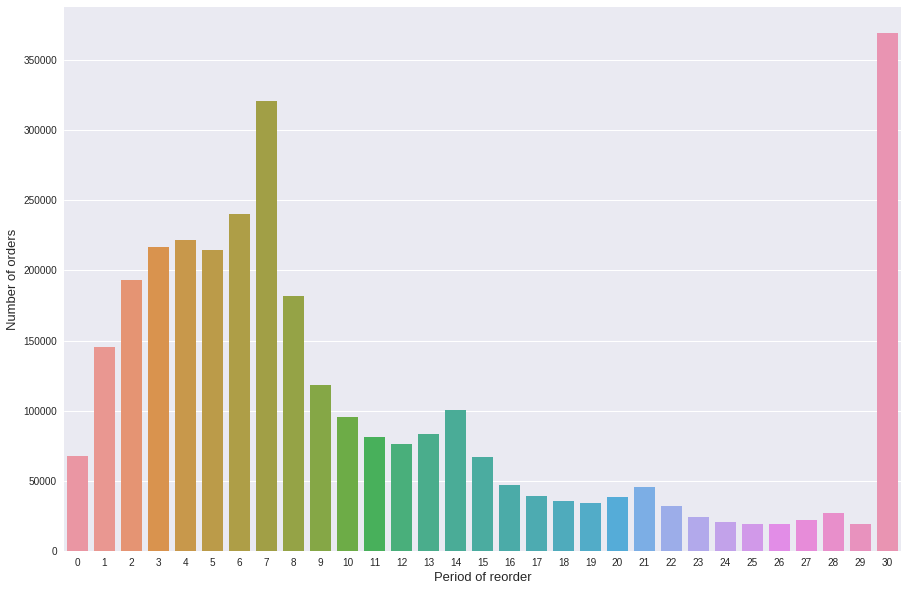

In [0]:
grouped = orders.groupby("order_id")["days_since_prior_order"].aggregate("sum").reset_index()
grouped = grouped.days_since_prior_order.value_counts()

from matplotlib.ticker import FormatStrFormatter
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Period of reorder', fontsize=13)
plt.show()

People usually reorder either after 1 week or after 1 month.

##Orders in the whole dataset

Number and ratio  of orders from the three datasets (prior, train, test).

In [0]:
grouped = orders.groupby("eval_set")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped

,eval_set,Total_orders,Ratio
0,prior,3214874,0.940
1,test,75000,0.022
2,train,131209,0.038


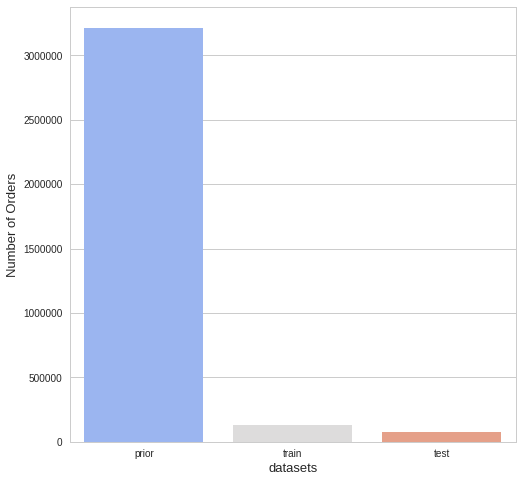

In [0]:
grouped  = grouped.groupby(['eval_set']).sum()['Total_orders'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(grouped.index, grouped.values, palette='coolwarm')
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('datasets', fontsize=13)
plt.show()

##Customers in the whole dataset

Let's check the total number of unique customers in the three datasets (prior, train, test).

In [0]:
print("Number of unique customers in the whole dataset : ",len(set(orders.user_id)))

Number of unique customers in the whole dataset :  206209


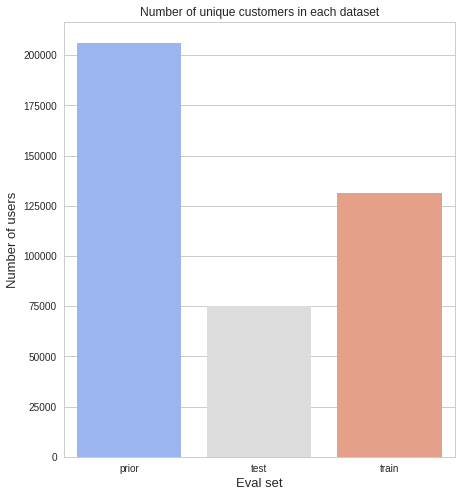

In [0]:
grouped = orders.groupby("eval_set")["user_id"].apply(lambda x: len(x.unique()))

plt.figure(figsize=(7,8))
sns.barplot(grouped.index, grouped.values, palette='coolwarm')
plt.ylabel('Number of users', fontsize=13)
plt.xlabel('Eval set', fontsize=13)
plt.title("Number of unique customers in each dataset")
plt.show()

##Orders made by each customer

Let's check the number of orders made by each costumer in the whole dataset.

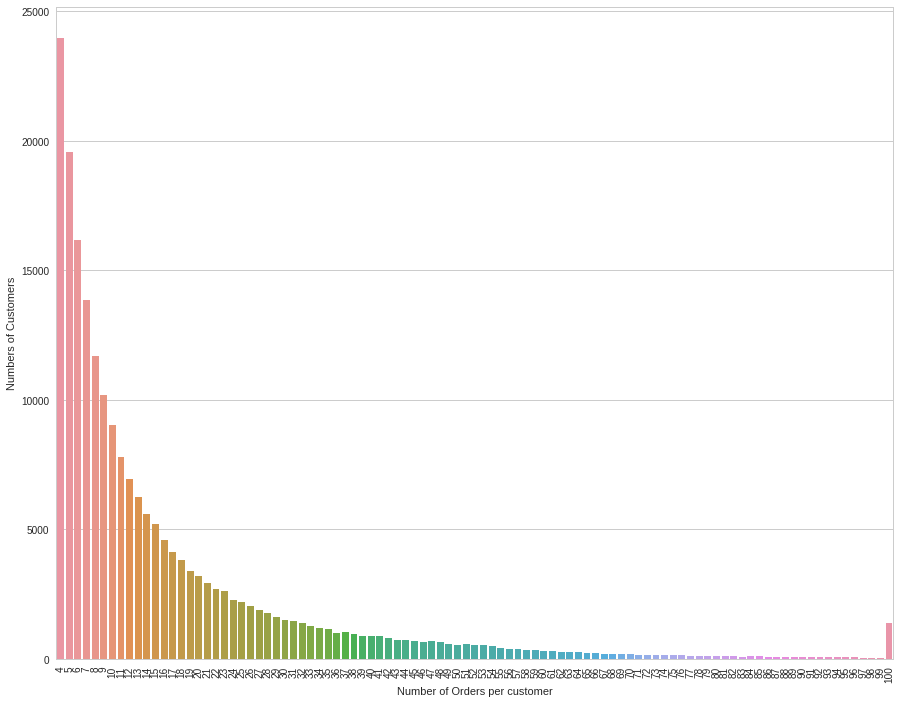

In [0]:
grouped = orders.groupby('user_id')['order_id'].apply(lambda x: len(x.unique())).reset_index()
grouped = grouped.groupby('order_id').aggregate("count")

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15, 12))
sns.barplot(grouped.index, grouped.user_id)
plt.ylabel('Numbers of Customers')
plt.xlabel('Number of Orders per customer')
plt.xticks(rotation='vertical')
plt.show()

We can observe that most customers made  4 orders.

Now let's explore the items datasets (products,  departments and aisles files.)

In [0]:
#display first five rows of our dataset.
products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [0]:
#display first five rows of our dataset.
departments.head(5)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [0]:
#display first five rows of our dataset.
aisles.head(5)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


Now let's combine them in a single dataframe

In [0]:
items  = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
items.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


##Most important Departments  (by number of products)

In [0]:
grouped = items.groupby("department")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
grouped

,department,Total_products,Ratio
17,personal care,6563,0.132
20,snacks,6264,0.126
16,pantry,5371,0.108
3,beverages,4365,0.088
10,frozen,4007,0.081
7,dairy eggs,3449,0.069
11,household,3085,0.062
6,canned goods,2092,0.042
9,dry goods pasta,1858,0.037
19,produce,1684,0.034


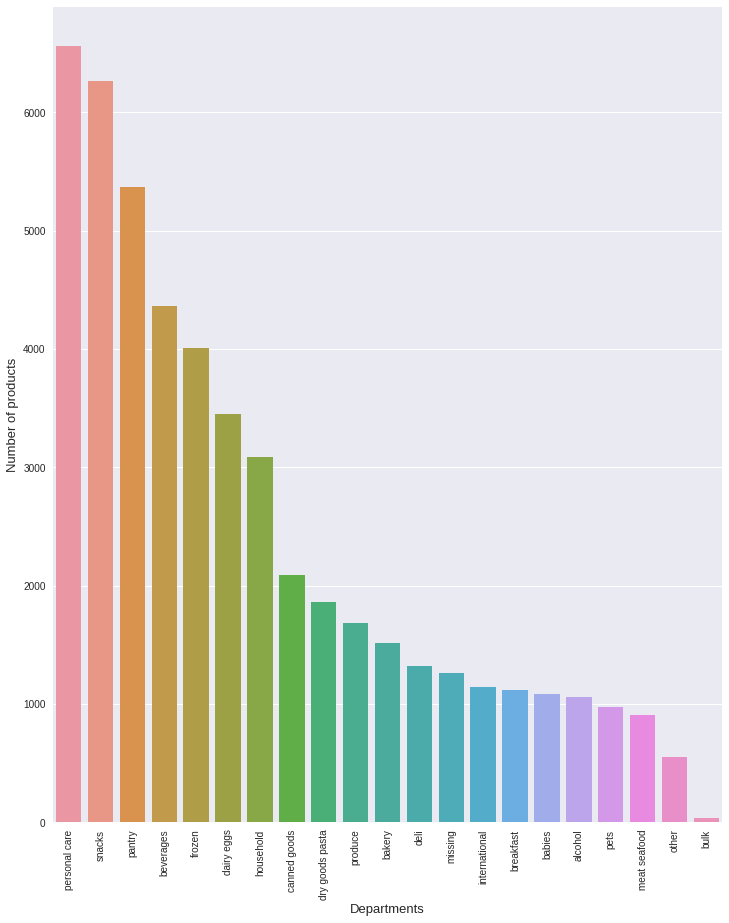

In [0]:
grouped  = grouped.groupby(['department']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

##Most important Aisles in each Department (by number of Products)

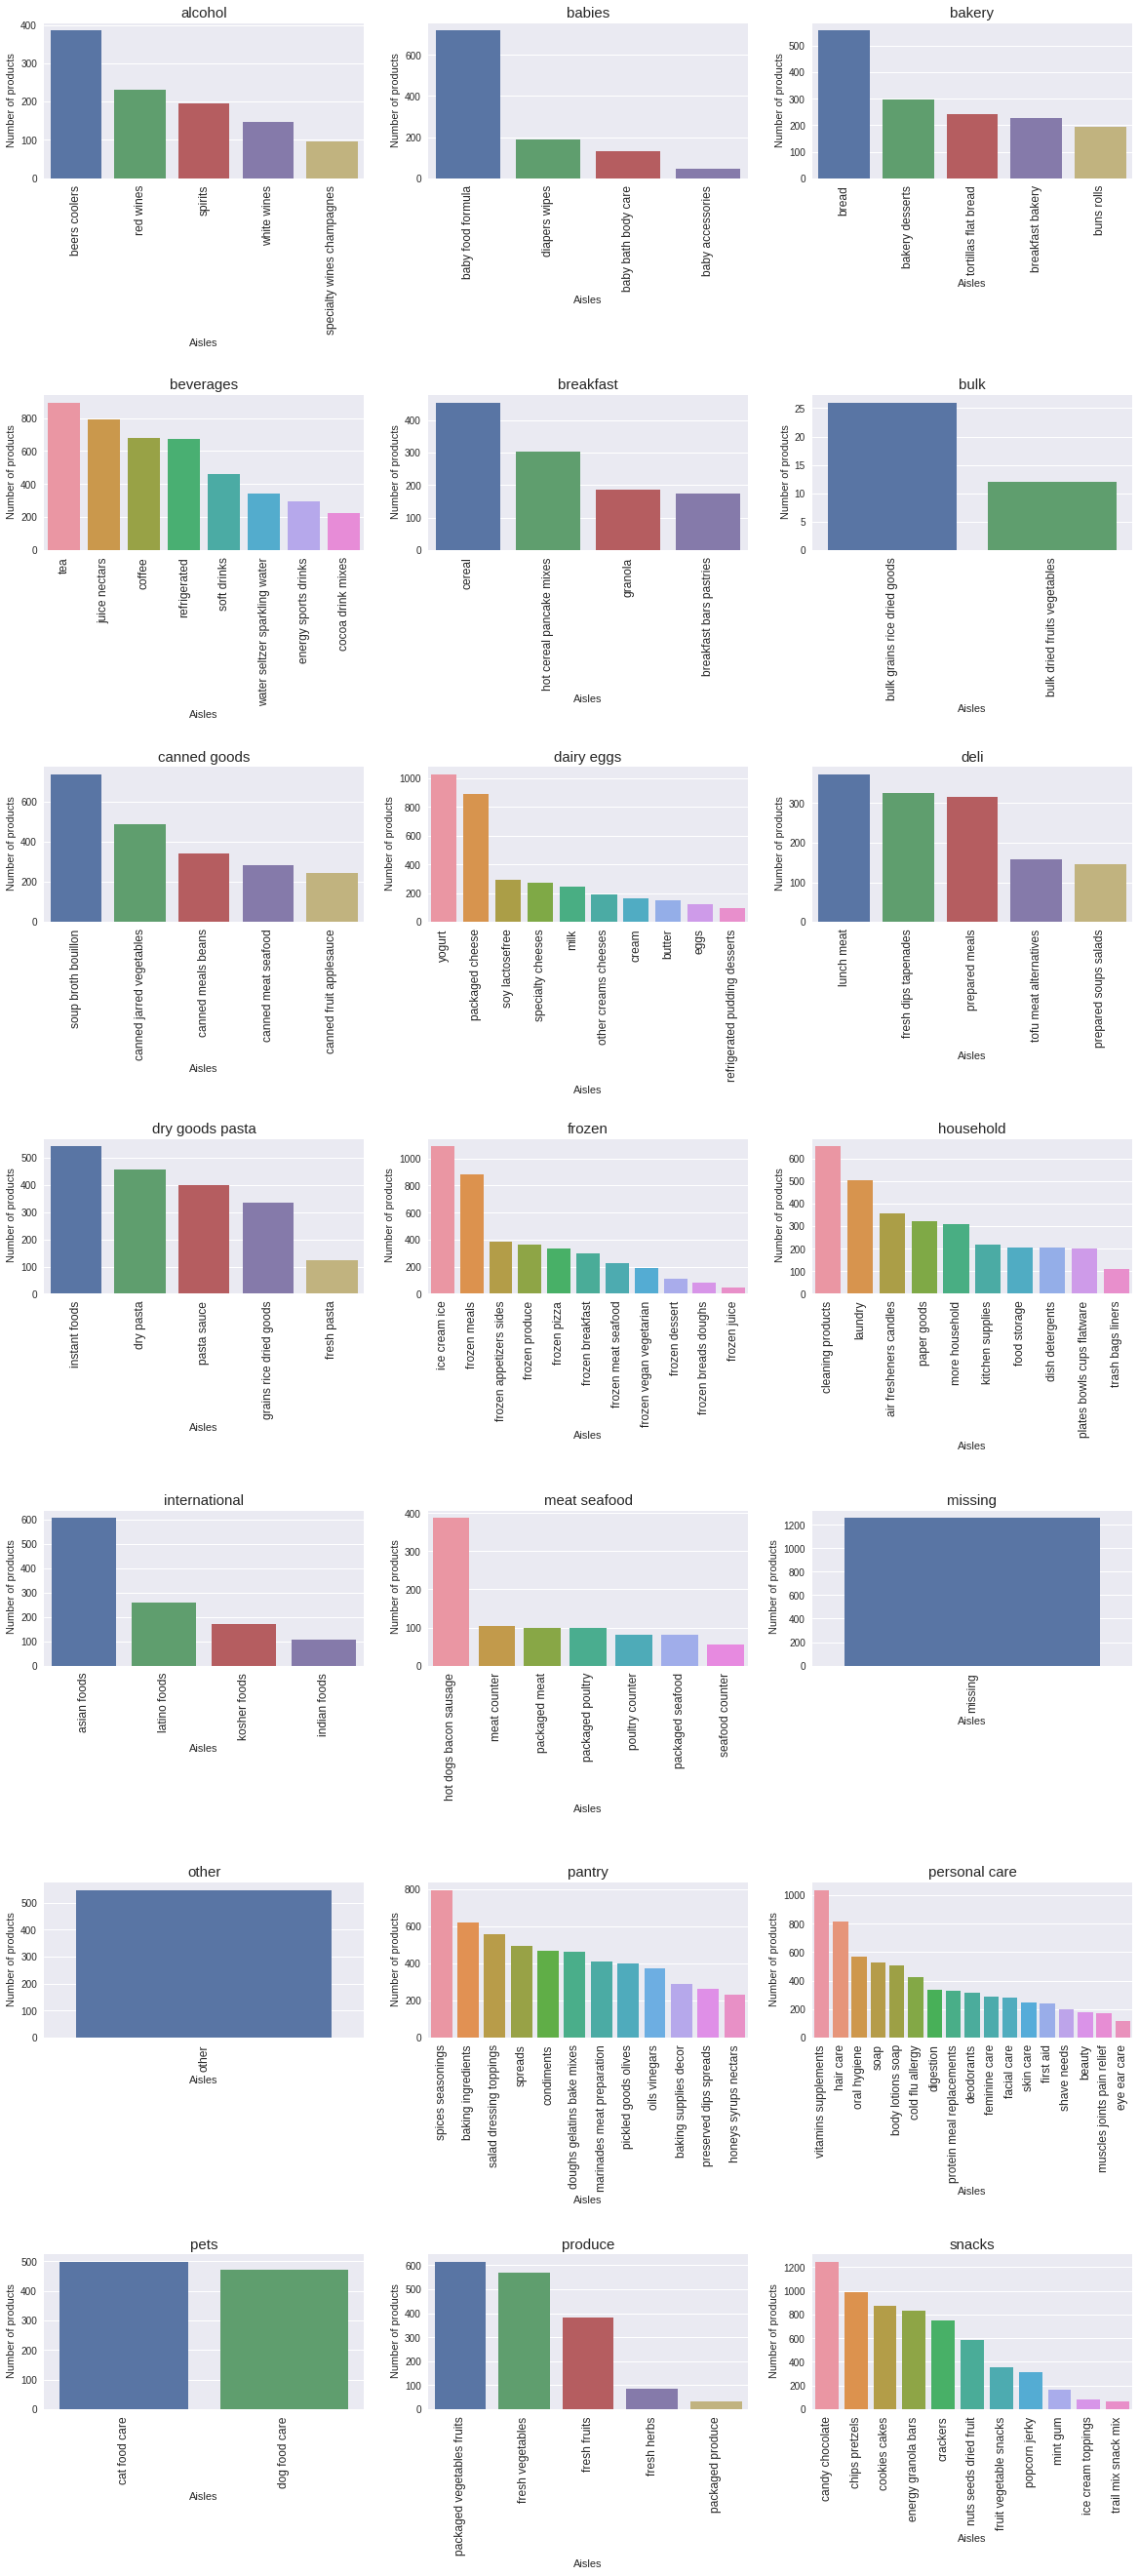

In [0]:
grouped = items.groupby(["department", "aisle"])["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

##Most important Aisles over all Departments (by number of Products)

In [0]:
grouped = items.groupby("aisle")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped = grouped.sort_values(by='Total_products', ascending=False)[:20]
grouped

,aisle,Total_products,Ratio
85,missing,1258,0.025
18,candy chocolate,1246,0.025
71,ice cream ice,1091,0.022
130,vitamins supplements,1038,0.021
133,yogurt,1026,0.021
25,chips pretzels,989,0.020
125,tea,894,0.018
93,packaged cheese,891,0.018
59,frozen meals,880,0.018
31,cookies cakes,874,0.018


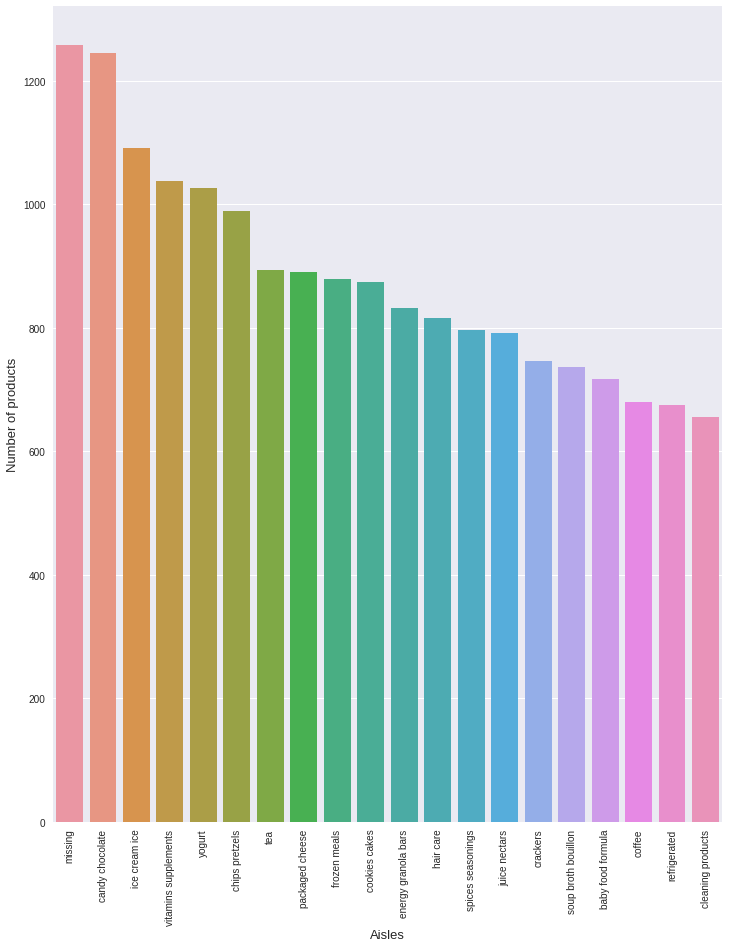

In [0]:
grouped  = grouped.groupby(['aisle']).sum()['Total_products'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()


**What are customers' favorite Departments and Aisles ?**

In [0]:

users_flow = orders[['user_id', 'order_id']].merge(order_products_train[['order_id', 'product_id']],
                                          how='inner', left_on='order_id', right_on='order_id')

users_flow = users_flow.merge(items, how='inner', left_on='product_id',
                                         right_on='product_id')

##Best Selling Departments  (number of Orders)

In [0]:
grouped = users_flow.groupby("department")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
grouped

,department,Total_orders,Ratio
19,produce,409087,0.295
7,dairy eggs,217051,0.157
20,snacks,118862,0.086
3,beverages,114046,0.082
10,frozen,100426,0.073
16,pantry,81242,0.059
2,bakery,48394,0.035
6,canned goods,46799,0.034
8,deli,44291,0.032
9,dry goods pasta,38713,0.028


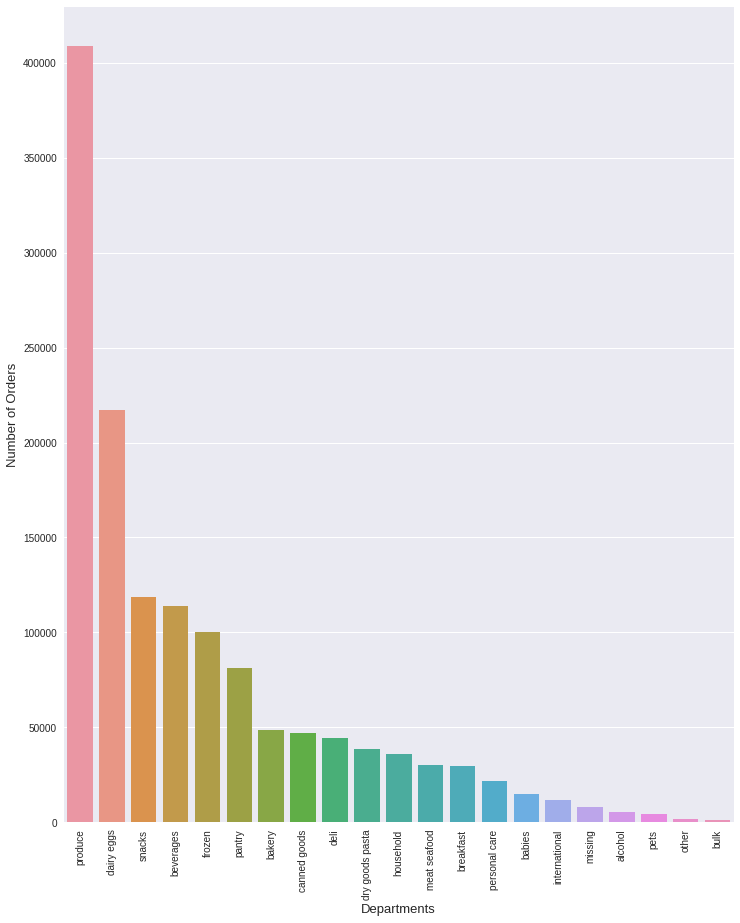

In [0]:
grouped  = grouped.groupby(['department']).sum()['Total_orders'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

##Best Selling Aisles in each Department (number of Orders)

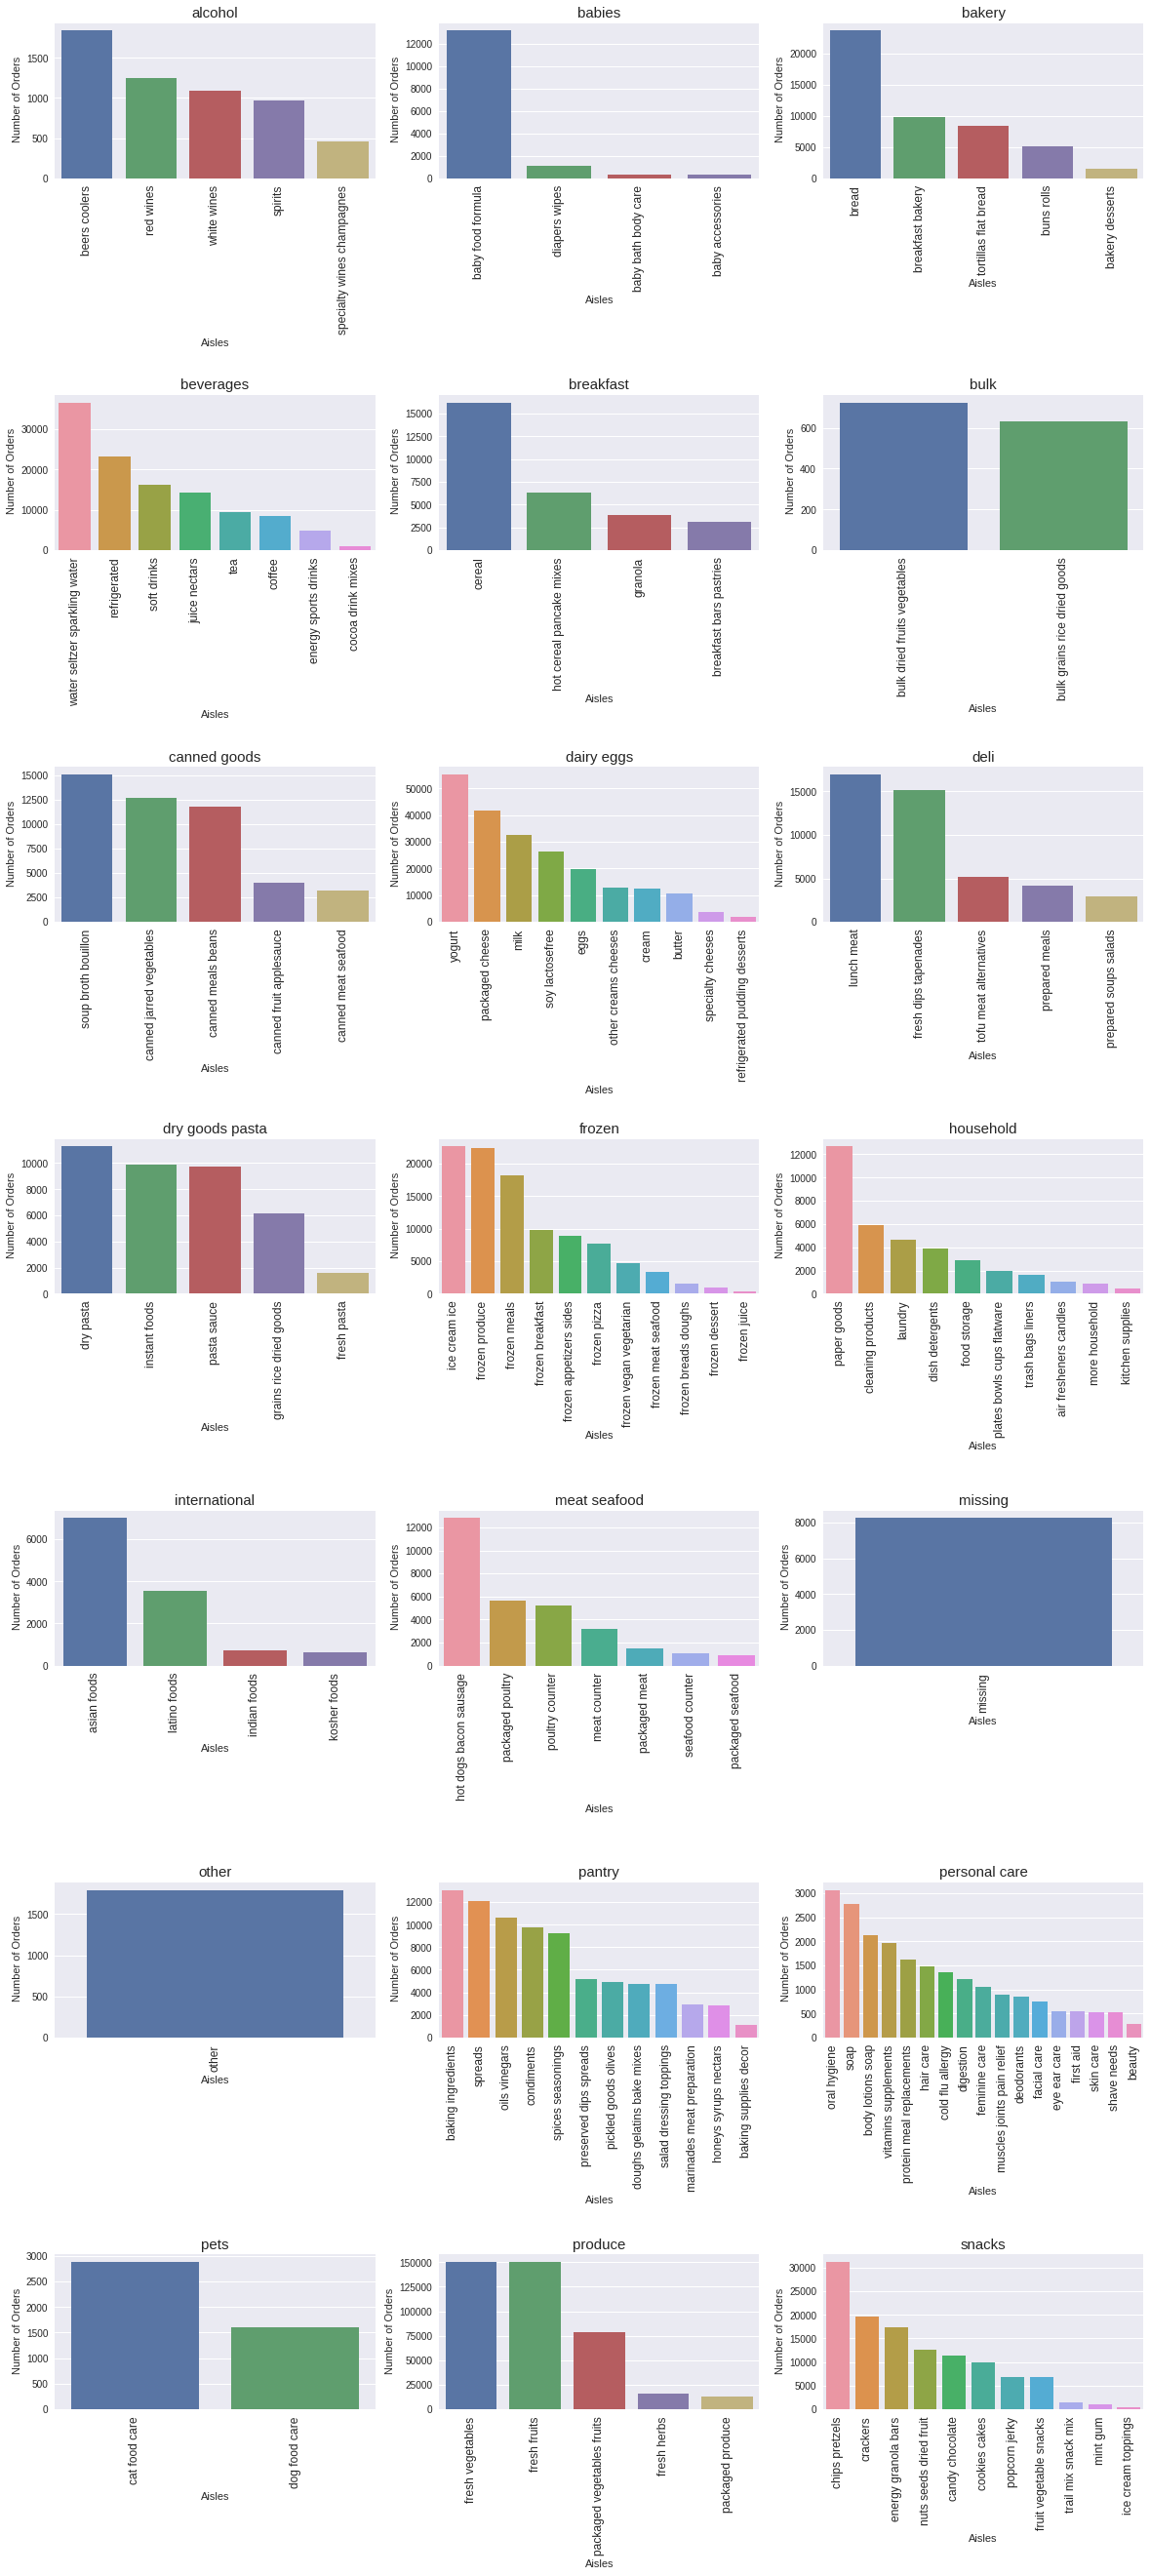

In [0]:
grouped = users_flow.groupby(["department", "aisle"])["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_orders , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of Orders")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

##Best Selling Aisles  over all Departments.

In [0]:
grouped = users_flow.groupby("aisle")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True )
grouped.head(10)

,aisle,Total_orders,Ratio
53,fresh vegetables,150609,0.109
50,fresh fruits,150473,0.109
98,packaged vegetables fruits,78493,0.057
133,yogurt,55240,0.040
93,packaged cheese,41699,0.030
131,water seltzer sparkling water,36617,0.026
83,milk,32644,0.024
25,chips pretzels,31269,0.023
119,soy lactosefree,26240,0.019
11,bread,23635,0.017


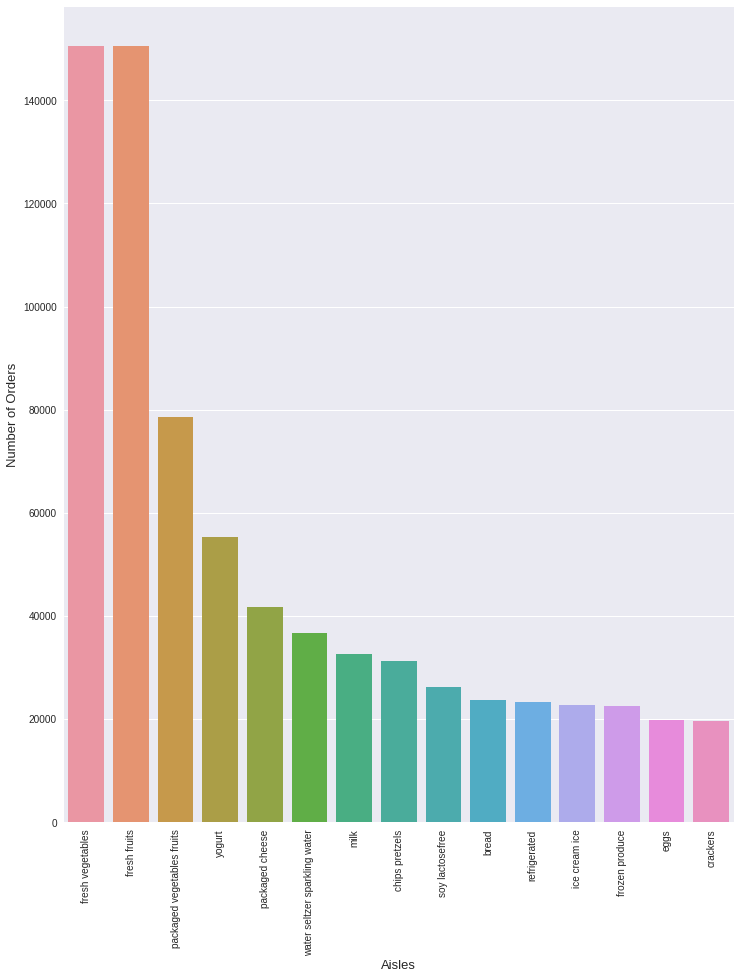

In [0]:
grouped  = grouped.groupby(['aisle']).sum()['Total_orders'].sort_values(ascending=False)[:15]

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()